# Speaker Identification on LibriSpeech with Transformer-based Architecture


**317 Classes - 97% Test Accuracy**

This notebook demonstrates a complete, reproducible pipeline for speaker identification (multi-class classification) using the LibriSpeech corpus. Although LibriSpeech is primarily designed for Automatic Speech Recognition (ASR), the dataset’s rich speaker labeling makes it well-suited for speaker ID.

**Key Highlights:**
- **Docker container**: NVIDIA's 25.02 Tensorflow Docker image - for training on RTX Blackwell architecture GPUs *.
- **34,342 recordings** from LibriSpeech (train-clean-100, dev-other, and test-other).
- **Preprocessing pipeline** includes feature extraction via Mel-Frequency Cepstral Coefficients (MFCCs) with delta and delta-delta coefficients.
- **Architecture**: Transformer-inspired with layer normalization, multi-head attention, convolution, and fully connected layers.
- **Regularization** includes exponential decay learning rate schedule, orthogonal regularizer, early stopping, and dropout.
- **Mixed precision training**: accelerates training and reduces VRAM usage by combining FP16 compute with FP32-stable accumulation.
- **Scaled Brier Loss**: optimizes probabilistic error, scaled to prevent gradient underflow with mixed precision.
- **OOP**: subclassed model, loss function, and callbacks.
- **K-fold cross-validation** to verify result robustness.
- **Model evaluation** using weighted F1, precision, recall, and accuracy.
- **Probabilistic Accuracy** assessed via brier score and distributions of max predicted probability for correct and incorrect predictions. 
- **Temperature Scaling** for calibrating predicted probabilities to reduce overconfidence.

**Dataset:** [LibriSpeech](https://www.openslr.org/12)

**Note:** This notebook presents the final trained model. Model architecture and hyperparameter tuning experiments have been excluded for brevity and readability.

**Environment Note: [NVIDIA TensorFlow Container](https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tensorflow?version=25.02-tf2-py3-igpu)** *

This project trains with TensorFlow on an NVIDIA **Blackwell-class** GPU. At the time of writting, TensorFlow’s standard pip wheels were not consistently reliable on NVIDIA Blackwell-class GPUs, largely because Blackwell support depends on a relatively new CUDA/cuDNN stack. A practical workaround is to run TensorFlow from an NVIDIA NGC container, which ships a validated, GPU-ready TensorFlow build bundled with the appropriate CUDA 12.x libraries and drivers. See this repo's README.txt for more information. 


***
## **Imports**

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import warnings
warnings.filterwarnings(
    "ignore",
    message=r".*gradients.*(serializ|serialis|checkpoint).*",
    category=UserWarning,
)
import gc
import json
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.utils.io import capture_output

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import soundfile as sf
from librosa.feature import delta, mfcc

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

gpus = tf.config.list_physical_devices("GPU")
print(gpus)
for g in gpus:
    tf.config.experimental.set_memory_growth(g, True)
    
seed = 20
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

2026-01-26 03:50:20.358366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-26 03:50:20.367469: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-26 03:50:20.370398: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 5060 Ti, compute capability 12.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1769399421.370578  115838 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1769399421.402424  115838 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1769399421.404177  115838 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1769399421.405776  115838 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

***
## **Utilities**
We’ll begin by defining some reusable functions: 
- normalize_amplitudes 
- plot_training 
- make_ds 
- evaluate_model 
- calc_brier_score 
- evaluate_probabilistic_accuracy


In [2]:
def normalize_amplitudes(signal):
    """ Normalizes the signal by applying mean centering and scaling by the maximum of absolute value. 
    Signals are normalized before MFCC extraction, which includes a Short-Time Fourier Transform (STFT). Any constant offset in the waveform (a DC bias) shows up as a large magnitude
    at 0 Hz and can skew the low-frequency portion of the spectrum. Mean-centering removes this DC component. After centering, we scale by the maximum absolute amplitude to map values 
    to roughly [-1, 1]. This puts recordings on a common amplitude scale and tends to stabilize optimization by reducing variation in feature magnitudes across examples.
    """
    signal = signal - np.mean(signal)                                                                         # center about zero.
    max = np.max(np.abs(signal)) + 1e-7 if np.max(np.abs(signal)) == 0 else np.max(np.abs(signal))            # to avoid division by zero.
    return signal / max                                                                                       # scale to [-1, 1]. 

def plot_training(history, figsize=(26, 10)):
    """
    Plots training curves on a 2 by 1 subplot: epochs v. loss and epochs v. accuracy for the training set and validation set.
    Args:
        history: (history training object). history.history must contain val_loss and val_accuracy as dictionary keys.
        figsize (tuple): tuple of (width, height). each axes containing (loss and accuracy) will be half these lengths.
    """
    width, height = figsize[0], figsize[1]
    plt.figure(figsize=(width, height))
    fig, (ax1, ax2) = plt.subplots(1, 2)
  
    x = np.arange(1, len(history.history["loss"]) + 1)
    loss = history.history["loss"]
    metric = history.history['accuracy']
    val_loss = history.history["val_loss"]
    val_metric = history.history['val_accuracy']

    ax1.plot(x, loss)
    ax1.plot(x, val_loss)
    ax1.set_title('Training Loss')
    ax1.legend(['Loss', 'Val_Loss'])
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.figure.set_size_inches(int(width / 2), int(height / 2))
    ax1.grid(True)

    ax2.plot(x, metric)
    ax2.plot(x, val_metric)
    ax2.set_title('Training Metric')
    ax2.legend(['Accuracy', 'Val_Accuracy'])
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.figure.set_size_inches(int(width / 2), int(height / 2))
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def make_ds(X, y, batch_size, training=False, shuffle_buf=5000, random_seed=20):
    """
    Builds and returns a tf.data.Dataset from a generator function. This keeps memory usage low when working with large datasets.
    Args:
        X: (np.ndarray) model inputs.
        y: (np.ndarray) targets.
        batch_size: (int) size of batches.
        training: (bool) whether the dataset is to be used for training (True) or evaluation (False).
        shuffle_buf: (int) passed to buffer_size parameter of tf.data.Dataset.shuffle().
        random_seed: (int) passed to seed parameter of tf.data.Dataset.shuffle().
    Return:
        tf.data.Dataset.from_generator() object.
    """
    with capture_output() as cap:                   
        def gen():
            n = X.shape[0]
            for i in range(n):
                yield X[i], y[i]

        X = X.astype("float32", copy=False)
        y = y.astype("int32", copy=False)
        ds = tf.data.Dataset.from_generator(
            gen,
            output_signature=(
                tf.TensorSpec(shape=X.shape[1:], dtype=tf.float32), 
                tf.TensorSpec(shape=(y.shape[1:]), dtype=tf.int32)))
        if training:
            ds = ds.shuffle(shuffle_buf, seed=random_seed, reshuffle_each_iteration=True)

        return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

def evaluate_model(model, ds, set_name='Test'):
    """
    Evaluates a model over a set. Prints results of f1, recall, precision, and accuracy scores. 
    Args:
        model: (tf.keras.Model) trained model.
        ds: (tf.data.Dataset) containing batched tuples: (X, y).
        set_name (string) either 'Val' or 'Test'. This name will be used in the print statement.
    """
    with capture_output() as cap:
        test_preds = model.predict(ds, verbose=0)
    test_preds = np.argmax(test_preds, axis=1)                                               # Get max predicted probability.

    test_labels = list(map(lambda x: x[1].numpy(), ds))                                      # Extract labels.
    test_labels = np.concatenate(test_labels, axis=0)                                        # Concatenate items of labels list
    test_labels = np.argmax(test_labels, axis=1)                                             # Labels are one-hot encoded in this notebook. This returns the indices of 1's.
    weighted_f1 = f1_score(test_labels, test_preds, average='weighted')                      
    weighted_recall = recall_score(test_labels, test_preds, average='weighted')
    weighted_precision = precision_score(test_labels, test_preds, average='weighted')
    accuracy = accuracy_score(test_labels, test_preds)
    print("\nWeighted {} Set F1-score : {:.4f}".format(set_name, weighted_f1))
    print("Weighted {} Set Recall   : {:.4f}".format(set_name, weighted_recall))
    print("Weighted {} Set Precision: {:.4f}".format(set_name, weighted_precision))
    print("         {} Set Accuracy : {:.4f}\n".format(set_name, accuracy))
 
def calc_brier_score(predicted_probs, labels):
    """ Calculates multiclass Brier Score given an array of predicted class probabilities and input labels. 
    """
    brier_matrix = np.zeros(shape=predicted_probs.shape)                                    
    # Iterate over rows where each row is the predicted class probability distribution for some example. Store the true label as label_idx.
    for i in range(predicted_probs.shape[0]):
        label_idx = labels[i]
        # Iterate over columns where each column contains predicted probabilities of classes for some example.
        for j in range(predicted_probs.shape[1]):
            # The (1-p)**2 if the probability is for the true class label, else (0-p)**2.
            brier_matrix[i, j] = (1-predicted_probs[i, j])**2 if label_idx==j else (0-predicted_probs[i, j])**2
    # Sum over rows and columns, dividing by the number of examples for the average. 
    return np.sum(brier_matrix) / brier_matrix.shape[0]

def evaluate_probabilistic_accuracy(model, val_ds, test_ds):
    test_labels, val_labels = list(map(lambda x: x[1].numpy(), test_ds)), list(map(lambda x: x[1].numpy(), val_ds))
    test_labels, val_labels = np.concatenate(test_labels), np.concatenate(val_labels)
    test_labels, val_labels = np.argmax(test_labels, axis=-1), np.argmax(val_labels, axis=-1)
    
    test_output, val_output = model.predict(test_ds), model.predict(val_ds)
    test_preds, val_preds = np.argmax(test_output, axis=-1), np.argmax(val_output, axis=-1)
    test_probs, val_probs = np.max(test_output, axis=-1), np.max(val_output, axis=-1)
    brier_test = calc_brier_score(predicted_probs=test_output, labels=test_labels)
    brier_val = calc_brier_score(predicted_probs=val_output, labels=val_labels)
    print("Model Brier Score - Evaluated over the Test Set: {:.4f}".format(brier_test))
    print("Model Brier Score - Evaluated over the Val Set: {:.4f}".format(brier_val))
    
    # For test and val sets, split the predictions by correct / incorrect. This is for plotting distributions of max predicted probabilities. 
    correct_idxs_test, correct_idxs_val = np.argwhere(test_labels==test_preds).reshape(-1,), np.argwhere(val_labels==val_preds).reshape(-1,)
    incorrect_idxs_test, incorrect_idxs_val = np.argwhere(test_labels!=test_preds).reshape(-1,), np.argwhere(val_labels!=val_preds).reshape(-1,)
    correct_probs_test, correct_probs_val = test_probs[correct_idxs_test], val_probs[correct_idxs_val]
    incorrect_probs_test, incorrect_probs_val  = test_probs[incorrect_idxs_test], val_probs[incorrect_idxs_val]
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 5))
    # Correct predictions have max probabilities concentrated near 1, use a KDE; for incorrect predictions, use a histogram for a closer view.
    sns.kdeplot(correct_probs_test, ax=axes[0, 0])                 
    sns.histplot(incorrect_probs_test, ax=axes[0, 1])
    axes[0, 0].set_title("Correct Predictions Test")
    axes[0, 1].set_title("Incorrect Predictions Test")
    
    sns.kdeplot(correct_probs_val, ax=axes[1, 0])
    sns.histplot(incorrect_probs_val, ax=axes[1, 1])
    axes[1, 0].set_title("Correct Predictions Val")
    axes[1, 1].set_title("Incorrect Predictions Val")
    
    fig.suptitle("Empirical Distributions of Maximum Predicted Probabilities")
    plt.tight_layout()
    plt.show()

***
## **Download / Parse Dataset**

In this secton, we:
- Download LibriSpeech subsets and checksums. 
- Verify downloads via md5 checksums.
- Extract contents of .tar files.
- Store file paths and labels. 


**Dataset Directory Tree Structure: See [LibriSpeech's](https://www.openslr.org/12) README.TXT for more details.**
```
<LibriSpeech>                                # Corpus Root
    |
    .- train-clean-100/                      # Subset 
    |   |
        .- 19/                               # Speaker Unique ID
    |   |   |
            .- 198/                          # Chapter 
    |   |   |    |
                 .- 19-198.trans.txt         # Transcriptions for all audio in Chapter
                 .- 19*198*0000.flac         # Audio files

In [3]:
URLS = [r"https://openslr.trmal.net/resources/12/train-clean-100.tar.gz",                  # Store urls of subsets and checksum file in a list.
        r"https://openslr.trmal.net/resources/12/dev-other.tar.gz",
        r"https://openslr.trmal.net/resources/12/test-other.tar.gz",
        r'https://openslr.trmal.net/resources/12/md5sum.txt'
]                                                                                          # Create data directory.
DATA_DIR = '/workspace/Data'
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

for url in URLS:                                                                           # Download files.
   !curl -L --output-dir "{DATA_DIR}" -O "{url}"
   
md5sums = {}                                                                               # Empty dictionary {'.tar filenames': 'checksum values'}.
tar_files = [url.split('/')[-1] for url in URLS if '.tar.gz' in url]                       # List of .tar filenames for each subset.
with open('/workspace/Data/md5sum.txt', 'r') as r:
    for line in r:                                                                         # Iterate through lines in md5sum.txt (checksum values).
        for tar_file in tar_files:                                                         # Iterate through .tar filenames. 
            if tar_file in line:                                                           
                md5sum = line.split()[0] 
                md5sums[tar_file] = md5sum                                                 # Store .tar filename and it's checksum in md5sums dictionary.
for file, checksum in md5sums.items():                                                     # Run checksum for each key, value pair in md5sums.
    file_path = "/workspace/Data/" + file
    print(f'Running checksum for {file}')
    !echo "{checksum}  {file_path}" | md5sum -c -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6091M  100 6091M    0     0  20.7M      0  0:04:53  0:04:53 --:--:-- 20.9M 0  20.5M      0  0:04:56  0:01:26  0:03:30 21.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  299M  100  299M    0     0  17.9M      0  0:00:16  0:00:16 --:--:-- 20.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  313M  100  313M    0     0  13.2M      0  0:00:23  0:00:23 --:--:-- 19.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   600  100   600    0     0    852      0 --:--:-- --:--:-- --:--:--   853
Run

In [4]:
for tar_file in tar_files:
    path = '/workspace/Data/' + tar_file
    !tar -xzf "{path}" -C "{DATA_DIR}"                             # Extract data from .gz.tar files, storing contents in /workspace/Data/LibriSpeech/
print(os.listdir(DATA_DIR), '\n')

data_path = DATA_DIR + "/LibriSpeech"
fpaths, labels = [], []                                            # For storing paths of audio files and their labels (unique speaker IDs).
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".flac"):
            filepath = os.path.join(root, file)
            fpaths.append(filepath) 
            labels.append(filepath.split("/")[-3])
print(f"Found {len(fpaths)} audio files.\nLength of labels list: {len(labels)}")

['LibriSpeech', 'train-clean-100.tar.gz', 'dev-other.tar.gz', 'md5sum.txt', 'test-other.tar.gz'] 

Found 34342 audio files.
Length of labels list: 34342


***
## **Preprocessing**

### *a) Normalization / Padding / Feature Extraction*

Below are the steps for normalization, padding, and feature extraction. We first define a few constants to fix the shapes of the zero-filled arrays used to store the MFCCs and their delta features. To do this, we need to account for two details.

First, we enforce a uniform signal length MAX_LEN = 160,000 samples (10 seconds at 16 kHz) by applying either truncation or right-side zero padding (mutually exclusive) before computing features.

Second, Librosa implicitly pads the signal by n_fft // 2 zeros on both the left and right when computing the STFT. This affects the resulting number of time frames (N_FRAMES), which becomes the final dimension of the MFCC and delta arrays.

**Note**: Note: For signals longer than MAX_LEN, we normalize after truncation so the amplitude statistics are computed only from the retained portion of the samples. For signals shorter than MAX_LEN, we normalize before padding to avoid biasing the normalization statistics toward zero.

In [5]:
MAX_LEN, S_RATE, N_FFT, N_MFCC, HOP_LEN = 160_000, 16_000, 2048, 20, 512
MFCC_PAD_LEN = MAX_LEN + 2 * (N_FFT // 2)                                                  # Number of sample points in each signal after padding. 
N_FRAMES = 1 + (MFCC_PAD_LEN - N_FFT) // HOP_LEN

mfccs = np.zeros((len(fpaths), N_MFCC, N_FRAMES), dtype=np.float32)                        # Arrays for populating extracted features. 
deltas1 = np.zeros((len(fpaths), N_MFCC, N_FRAMES), dtype=np.float32)
deltas2 = np.zeros((len(fpaths), N_MFCC, N_FRAMES), dtype=np.float32)  
sample_rates = []                                                                          # For verifying a uniform sample rate. 
idx_skipped = []                                                                           # To record indices of files if they cannot be read.

for idx, filepath in enumerate(tqdm(fpaths, desc="Extracting MFCCs and Deltas")):
    try:
        signal, s_rate = sf.read(filepath)                                                 # Read file
        sample_rates.append(s_rate)                                                        # Record sample rate.
        
        if len(signal) > MAX_LEN:
            signal = signal[:MAX_LEN]                                                      # Truncate signals longer than our set maximum length.
            signal = normalize_amplitudes(signal)                                          # Normalize after truncation for longer signals.
        else:
            signal = normalize_amplitudes(signal)                                          # Normalize before padding for shorter signals.
            pad_width = MAX_LEN - len(signal) 
            signal = np.pad(signal, (0, pad_width), mode='constant', constant_values=0)    # Pad shorter signals to MAX_LEN
        
        signal_mfcc = mfcc(y=signal, sr=s_rate, S=None, n_mfcc=N_MFCC, dct_type=2, norm='ortho', lifter=0, mel_norm='slaney')
        signal_delta1 = delta(data=signal_mfcc, width=9, order=1, axis=-1, mode='interp')
        signal_delta2 = delta(data=signal_mfcc, width=9, order=2, axis=-1, mode='interp')
        mfccs[idx, :, :] = signal_mfcc
        deltas1[idx, :, :] = signal_delta1
        deltas2[idx, :, :] = signal_delta2

    except sf.LibsndfileError as e:                                                        # Skip iteration if a read error occurs.
        idx_skipped.append(idx)                                                            # Record index of skipped file.
        print(f"Error reading {filepath}: {e}")
        continue

labels_exc = labels.copy()                                                                 # If any files skipped, remove their labels.
if len(idx_skipped) > 0:
    print(f"\nSkipped {len(idx_skipped)} files due to read errors. Removing from dataset.\n")
    
    for i in idx_skipped[::-1]:                                                            # Remove entries in reverse order to avoid index shifting.
        mfccs = np.delete(mfccs, i, axis=0)
        deltas1 = np.delete(deltas1, i, axis=0)
        deltas2 = np.delete(deltas2, i, axis=0)
        del labels_exc[i]
else:
    print("\nNo files were skipped.\n")

if len(np.unique(sample_rates)) == 1:                                                      # Verify uniform sample rate.
    print(f"Sample Rate: {np.unique(sample_rates)[0]}\n")

Extracting MFCCs and Deltas: 100%|██████████| 34342/34342 [05:47<00:00, 98.75it/s] 


No files were skipped.

Sample Rate: 16000



### *b) Check Duplicates*

The code below checks for duplicate data points. Our method is not a rigorous guarantee of zero duplicates, but it’s a practical sanity check for our purposes; LibriSpeech is widely used, making it likely to have been flagged for duplication if present. Therefore, we merely check for exact duplicate MFCC feature arrays and transcripts. No duplicate MFCCs were found, and only five duplicate transcript pairs appeared. Those duplicates are short, generic phrases that can naturally recur, and 5 pairs out of 
34,342 transcripts is negligible. We can proceed with a bit more confidence that duplicates are not present.

In [6]:
mfcc_flat_df = pd.DataFrame( mfccs.reshape( [mfccs.shape[0], -1] ))                   # Flatten the last two dimensions before populating dataframe.
print(f"Number of duplicate features: {mfcc_flat_df.duplicated().sum()}")
transcripts = []
duplicates = []                                                                       # List of tuples: indices of duplicate items in transcripts. 

for path in [DATA_DIR + '/LibriSpeech/' + dir for dir in ['train-clean-100/', 'dev-other/', 'test-other/']]:
    for speaker_dir in [path + speakers for speakers in os.listdir(path)]:
        for ch_dir in [speaker_dir + '/' + ch for ch in os.listdir(speaker_dir)]:
            transcript_files = [f for f in os.listdir(ch_dir) if f.endswith('.txt')]
            assert len(transcript_files) == 1, 'chapter dir has more than one transcript file'
            transcript_fpath = ch_dir + '/' + transcript_files[0]
            
            with open(transcript_fpath, 'r') as file:                                 # Iterate through each transcript of each transcript file. 
                for line in file.readlines():
                    transcript = ' '.join(line.split()[1:]).strip()
                    if transcript in transcripts:
                        idx_dup = transcripts.index(transcript)
                        duplicates.append((idx_dup, len(transcripts)))                # Append a tuple of indices of duplicates.
                    transcripts.append(transcript)
print(f"Number of duplicate transcripts: {len(duplicates)}")
print(f"Number of transcripts: {len(transcripts)}")

Number of duplicate features: 0
Number of duplicate transcripts: 5
Number of transcripts: 34342


In [7]:
for idx_tuple in duplicates:                                                          # Print the 5 duplicate transcripts.
    print(transcripts[idx_tuple[0]])                                                  
    print(transcripts[idx_tuple[1]], '\n')
del mfcc_flat_df, transcripts, duplicates

KNIT TWO TOGETHER TWICE
KNIT TWO TOGETHER TWICE 

AND LONGITUDE SEVENTEEN DEGREES
AND LONGITUDE SEVENTEEN DEGREES 

SICK SICK
SICK SICK 

YES
YES 

THANK YOU NO
THANK YOU NO 



We’ll create a list of unique speaker IDs called classes, where each ID’s index serves as its integer class label. To remove duplicates, we’ll use set(), but sets do not preserve a deterministic order—recreating classes could produce a different ordering (and therefore different label assignments). To keep the mapping fixed and reproducible, we’ll save classes to a .json file.

In [ ]:
artifacts_dir = '/workspace/artifacts'

""" Leave this commented out to avoid overwriting the classes list. If you’re reproducing this notebook, load the saved list from /workspace/artifacts/classes.json (shown below).

classes = list(set(labels_exc))
artifacts_dir = '/workspace/artifacts'
if not os.path.isdir(artifacts_dir):
    os.mkdir(artifacts_dir)
with open(artifacts_dir + "/classes.json", "w", encoding="utf-8") as f:
    json.dump(classes, f, ensure_ascii=False, indent=2)
"""
with open(artifacts_dir + "/classes.json", encoding="utf-8") as f:
    classes = json.load(f)

In [9]:
class_map = {name: i for i, name in enumerate(classes)}                                                          # Create class map ( speaker ID ->  integer class label).
inv_class_map = {i: name for i, name in enumerate(classes)} 

targets = [class_map[speaker_id] for speaker_id in labels_exc]                                                   # Map the Speaker ID's to target values.
targets = np.array(targets).astype('int32')                                                                      # Create targets array.
targets = np.eye(317)[targets]                                                                                   # One-hot encode targets.
inputs = np.concatenate((mfccs, deltas1, deltas2), axis=1)                                                       # Concatenate all model inputs.

shuffle_idxs = np.arange(len(targets))                                                                           # Shuffle inputs and targets.
np.random.shuffle(shuffle_idxs)
targets = targets[shuffle_idxs]
inputs = inputs[shuffle_idxs, :, :]

INPUT_SHAPE = (N_MFCC*3, N_FRAMES)                                                                               # Input and output shapes of our model.
N_CLASSES = len(class_map)
class_values, class_counts = np.unique(np.argmax(targets, axis=-1), return_counts=True)                          # To get a sense of class imbalance.

print(f"mfccs shape: {mfccs.shape}, deltas1 shape: {deltas1.shape}, deltas2 shape: {deltas2.shape}\n")
print(f"inputs shape: {inputs.shape}, targets shape: {targets.shape}\n")
print(f"Number of classes: {N_CLASSES}]\n")
print(f"Unique values of number of examples per class:\n{np.unique(class_counts)}")

mfccs shape: (34342, 20, 313), deltas1 shape: (34342, 20, 313), deltas2 shape: (34342, 20, 313)

inputs shape: (34342, 60, 313), targets shape: (34342, 317)

Number of classes: 317]

Unique values of number of examples per class:
[ 24  26  31  33  50  52  55  56  60  61  63  66  68  69  71  72  73  76
  79  80  81  82  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 144 155 161 165 166]


### *c) Stratified Train-Validation-Test Splits*

Stratified sampling is important due to class imbalance. Since our targets are one-hot encoded, we pass np.argmax(targets, axis=-1) to stratify to preserve the class distribution across splits.

In [11]:
BATCH_SIZE = 128
X_train, X_temp, y_train, y_temp = train_test_split(inputs, targets, stratify=np.argmax(targets, axis=-1), test_size=.25, shuffle=True, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=np.argmax(y_temp, axis=-1), test_size=.20, shuffle=True, random_state=seed)

with capture_output() as cap:
    train_ds = make_ds(X_train, y_train, BATCH_SIZE, training=True, shuffle_buf=5000, random_seed=seed)
    val_ds   = make_ds(X_val, y_val, BATCH_SIZE, training=False)
    test_ds  = make_ds(X_test, y_test, BATCH_SIZE, training=False)

del_objs = [
    'fpaths', 'labels', 'sample_rates', 'labels_exc', 'mfccs', 'deltas1', 'deltas2', 
    'X_train', 'X_temp', 'X_val', 'X_test', 'y_train', 'y_temp', 'y_val', 'y_test'
    ]
for name in del_objs:
    if name in globals():
        del globals()[name]
gc.collect()

1599

***
## **Modelling**

**In this section**: 

- Implement custom classes for the classifier model, temperature scaling layer, loss function, and early-stopping callback.
- Specify hyperparameters.
- Train the model.
- Plot training curves.
- Evaluate performance and probabilistic accuracy.
- Apply temperature scaling and re-evaluate probabilisitic accuracy.
- Assess sensitivity to train/validation/test splits via k-fold cross-validation.

**Note** Refer to the inline comments in call() below for a walkthrough of the model’s forward pass

### *a) Custom Classes*

In [175]:
class TempLayer(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.t = self.add_weight(
            name="temp",
            shape=(),
            initializer=tf.keras.initializers.Constant(1.0),
            trainable=True,
            dtype=tf.float32,
        )
    def call(self, x):
        t = tf.nn.softplus(self.t) + 1e-6
        return x / t

class Classifier(tf.keras.Model):
    def __init__(
        self,
        input_shape,
        atten_num_heads,
        atten_key_dim,
        dense1_units,
        dense2_units,
        conv_filters,
        conv_kernel_size,
        conv_padding,
        conv_activation, 
        dense1_kernel_reg,
        dense2_kernel_reg,
        logits_kernel_reg,
        dropout,
        n_classes,
        name="classifier",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)
        # Constructor Args
        self.input_shape_ = input_shape
        self.atten_num_heads = atten_num_heads
        self.atten_key_dim = atten_key_dim
        self.dense1_units = dense1_units
        self.dense2_units = dense2_units
        self.n_classes = n_classes
        self.conv_filters = conv_filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_padding = conv_padding
        self.conv_activation = conv_activation 
        self.dropout = dropout
        
        # Network Layers
        self.permute = layers.Permute((2, 1), name="permute")
        self.norm = layers.LayerNormalization(axis=-1, name="norm")
        self.attn = layers.MultiHeadAttention(num_heads=atten_num_heads, key_dim=atten_key_dim, name="attn")
        self.conv = layers.Conv1D(conv_filters, conv_kernel_size, padding=conv_padding, activation=conv_activation, name='conv1d')
        self.flatten = layers.Flatten(name="flatten")
        self.dense1 = layers.Dense(dense1_units, activation="relu", name="dense1", kernel_regularizer=dense1_kernel_reg)
        self.dense2 = layers.Dense(dense2_units, activation="relu", name="dense2", kernel_regularizer=dense2_kernel_reg)
        self.dropout = layers.Dropout(dropout, name='dropout')
        self.logits = layers.Dense(n_classes, activation=None, name="logits", kernel_regularizer=logits_kernel_reg)
        self.temp = TempLayer()
        self.softmax = layers.Activation("softmax", dtype="float32", name="softmax")

    def call(self, inputs, training=None, mask=None):
        x = self.permute(inputs)                                           # permute so that attention weights are calculated for time axis. 
        x = self.norm(x, training=training)                              
        x = self.attn(x, x, use_causal_mask=True, training=training)       # calculate attention weights to scale and aggregate context vectors along time axis.
        x = self.permute(x)                                                # permute to shape [BATCH, TIME, FEATURES].
        x = self.conv(x, training=training)                                # convolution captures local temporal patterns.
        x = self.flatten(x)                                                # flatten for dense layers.
        x = self.dense1(x, training=training)                              # linear projections with nonlinear activations to model nonlinear relationships
        x = self.dropout(x)                                                # for regularization
        x = self.dense2(x, training=training)
        x = self.logits(x, training=training)                              # logits with shape of n_classes.
        x = self.temp(x, training=True)                                    # temperature scaling. we will freeze this before initial training. 
        
        return self.softmax(x)                                             # maps logits of every training example to a probability space.

    def build(self, input_shape):
        super().build(input_shape)

    def get_config(self):
        config = super().get_config()
        config.update(
            dict(
                input_shape=self.input_shape_,
                atten_num_heads=self.atten_num_heads,
                atten_key_dim=self.atten_key_dim,
                dense1_units=self.dense1_units,
                dense2_units=self.dense2_units,
                n_classes=self.n_classes,
                conv_filters=self.conv_filters,
                conv_kernel_size=self.conv_kernel_size,
                conv_padding=self.conv_padding,
                conv_activation=self.conv_activation,
                dropout=self.dropout
            )
        )
        return config
        
class BrierLoss(tf.keras.losses.Loss):
    """Calculates Brier Loss with a scale parameter to avoid underflow with mixed precision.
    """
    def __init__(self, scale=1.0, name="brier_loss", reduction=tf.keras.losses.Reduction.AUTO):
        super().__init__(name=name, reduction=reduction)
        self.scale = float(scale)

    def call(self, y_true, y_pred):
        # Ensure we're working in float32 to avoid mixed-precision underflow issues
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        return self.scale * tf.reduce_mean(tf.square(y_true - y_pred))

    def get_config(self):
        config = super().get_config()
        config.update({"scale": self.scale})
        return config

class EarlyStop(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        acc = logs.get("accuracy")
        if val_acc is not None and val_acc > .975:
            self.model.stop_training = True
            print("Val Accuracy Threshold Reached. Stopping Training")

### *b) Configuration / Training*

In [176]:
model_config = {                                                                                # Hyperparameters / configuration.
  "input_shape": INPUT_SHAPE,
  "atten_num_heads": 4,
  "atten_key_dim": 15,
  "dense1_units": 512,
  "dense2_units": 1024,
  "conv_filters": 256,
  "conv_kernel_size": 128, 
  "conv_padding": 'causal',
  "conv_activation": 'relu',
  "dense1_kernel_reg": 'orthogonal columns',
  "dense2_kernel_reg": 'orthogonal rows',
  "logits_kernel_reg": 'orthogonal columns',
  "dropout": 0.1,
  "n_classes": N_CLASSES
}
with open(artifacts_dir + "/model_config.json", "w", encoding="utf-8") as f:                    # Store configuration.
    json.dump(model_config, f, indent=2)

model_kwargs = {key: val for key, val in model_config.items()}                                  # For instantiating model objects.       
for key in ["dense1_kernel_reg", "dense2_kernel_reg", "logits_kernel_reg"]:                     # Remove descriptions of dense kernel regularizers. 
    del model_kwargs[key]                                                                       # Dense regularizers are defined and passed with model_kwargs to Classifier class.

EPOCHS = 20
N_TRAIN_BATCHES = int(np.ceil(len(inputs)*.75)) // BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(                                   # Define learning rate schedule.
    initial_learning_rate=1e-3, 
    decay_steps=int(EPOCHS * N_TRAIN_BATCHES) // 10, 
    decay_rate=0.75, staircase=True)

checkpoints_dir = "/workspace/checkpoints"
if not os.path.isdir(checkpoints_dir):
    os.mkdir(checkpoints_dir)
model_checkpoint = checkpoints_dir + "/model_cp.ckpt"
checkpoint = tf.keras.callbacks.ModelCheckpoint(                                                # Checkpoint callback for storing model weights during training.
    model_checkpoint,
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStop()                                                                        # Instantiate early stopping callback object.

# Define model, compile, and train.
ortho_reg_cols = tf.keras.regularizers.OrthogonalRegularizer(mode='columns')                    # Kernel regularizer for the first and last (logits) dense layers.
ortho_reg_rows = tf.keras.regularizers.OrthogonalRegularizer(mode='rows')                       # Kernel regularizer for the second dense layer. 

model = Classifier(                                                                             # Instantiate model.
    dense1_kernel_reg=ortho_reg_cols, 
    dense2_kernel_reg=ortho_reg_rows, 
    logits_kernel_reg=ortho_reg_cols, 
    **model_kwargs
)
loss_fn = BrierLoss(scale=10000)                                                                # Instantiate custom loss function object. 
model.compile(                                                                                  # Compile model
    loss=loss_fn, 
    metrics=['accuracy'],                                                                       # Performance will also be evaluated with F1, Precision, and Recall.
    optimizer=tf.keras.optimizers.Adam(lr_schedule, beta_1=.95, beta_2=.97)                     # Adam w/ adjusted ema parameters for 1st and 2nd moments about origin of gradients.
)

model.get_layer(model.layers[-2].name).trainable = False                                        # Freeze the temperature scaling layer

with capture_output() as cap:
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[checkpoint, early_stop])

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

### *c) Plot Training / Evaluation*

<Figure size 1800x800 with 0 Axes>

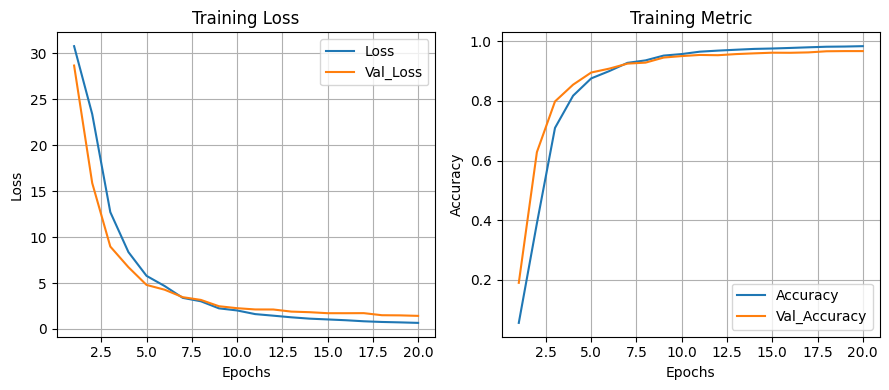

In [177]:
plot_training(history, figsize=(18, 8))   

In [178]:
print("Evaluating model with weights of last epoch.")
evaluate_model(model, test_ds, set_name='Test')                       

last_epoch_cp = checkpoints_dir + "/last_epoch.weights.ckpt"              # Save weights of last epoch.
model.save_weights(last_epoch_cp)   

model_cp = Classifier(                                                    # Define another model instance and load checkpoint weights for evaluation.
    dense1_kernel_reg=ortho_reg_cols, 
    dense2_kernel_reg=ortho_reg_rows, 
    logits_kernel_reg=ortho_reg_cols, 
    **model_kwargs
)
model_cp.load_weights(model_checkpoint)

print("Evaluating model with weights of checkpoint.")
evaluate_model(model_cp, test_ds, set_name='Test')

Evaluating model with weights of last epoch.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Weighted Test Set F1-score : 0.9651
Weighted Test Set Recall   : 0.9668
Weighted Test Set Precision: 0.9713
         Test Set Accuracy : 0.9668

Evaluating model with weights of checkpoint.

Weighted Test Set F1-score : 0.9651
Weighted Test Set Recall   : 0.9668
Weighted Test Set Precision: 0.9713
         Test Set Accuracy : 0.9668



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### *d) Results*

**Weighted Test Metrics**
- Accuracy: 0.9668
- Weighted F1: 0.9651
- Weighted Precision: 0.9713
- Weighted Recall: 0.9668

***
## **Probabilistic Accuracy**

**In this section**: 

- Brier score (multiclass): Measures overall probabilistic accuracy of a classification model. It is defined as the mean squared distance between the predicted probability vector and the one-hot true label. Brier scores for multiclass labels are in the range [0, 2], where a lower value means better-calibrated and more accurate probabilities (penalizes confident wrong predictions strongly).

- Display the distribution of max probabilities for correct predictions. This shows how confident the model is when it’s right, where probability mass concentrated at higher values reflects greater certainty on correct decisions.

- Plot the distribution of max probabilities for incorrect predictions to flag overconfident errors. If a large fraction of wrong samples have high max probability, the model is overconfident in its incorrect predictions. Ideally, this curve is concentrated at lower values.

- Apply temperature scaling to reduce overconfident probabilities on incorrect predictions. Re-evaluate probabilistic accuracy.

54/54 [==============================] - 1s 10ms/step
Model Brier Score - Evaluated over the Test Set: 0.0467
Model Brier Score - Evaluated over the Val Set: 0.0452


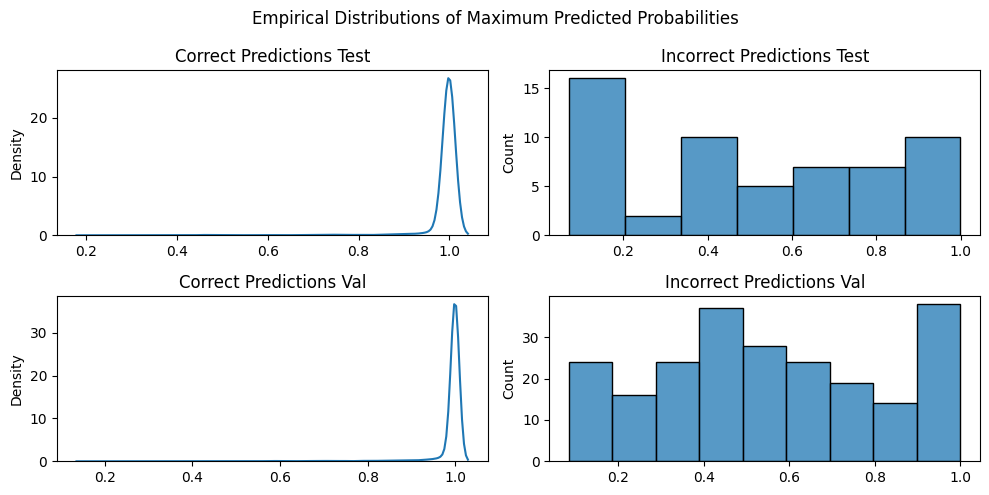

In [179]:
evaluate_probabilistic_accuracy(model, val_ds, test_ds)

### *a) Temperature Scaling*

Our model achieved high accuracy on the validation and test sets, but it still produces overly confident probabilities on incorrect predictions. To address this, we apply temperature scaling: freeze the weights of our subclassed model, recompile, and train for 20 epochs on the validation set while optimizing a single trainable temperature parameter. This calibration step should reduce the concentration of incorrect prediction probabilities near 1.

Epoch 1/10


     16/Unknown - 1s 11ms/step - loss: 0.2975 - accuracy: 0.9595

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


54/54 [==============================] - 1s 12ms/step - loss: 0.2678 - accuracy: 0.9621
Epoch 2/10
54/54 [==============================] - 1s 12ms/step - loss: 0.2607 - accuracy: 0.9614
Epoch 3/10
54/54 [==============================] - 1s 12ms/step - loss: 0.2632 - accuracy: 0.9604
Epoch 4/10
54/54 [==============================] - 1s 12ms/step - loss: 0.2645 - accuracy: 0.9630
Epoch 5/10
54/54 [==============================] - 1s 12ms/step - loss: 0.2631 - accuracy: 0.9598
Epoch 6/10
54/54 [==============================] - 1s 12ms/step - loss: 0.2570 - accuracy: 0.9614
Epoch 7/10
54/54 [==============================] - 1s 12ms/step - loss: 0.2484 - accuracy: 0.9621
Epoch 8/10
54/54 [==============================] - 1s 12ms/step - loss: 0.2509 - accuracy: 0.9627
Epoch 9/10
54/54 [==============================] - 1s 12ms/step - loss: 0.2517 - accuracy: 0.9620
Epoch 10/10
54/54 [==============================] - 1s 10ms/step
Model Brier Score - Evaluated over the Test Set: 0.046

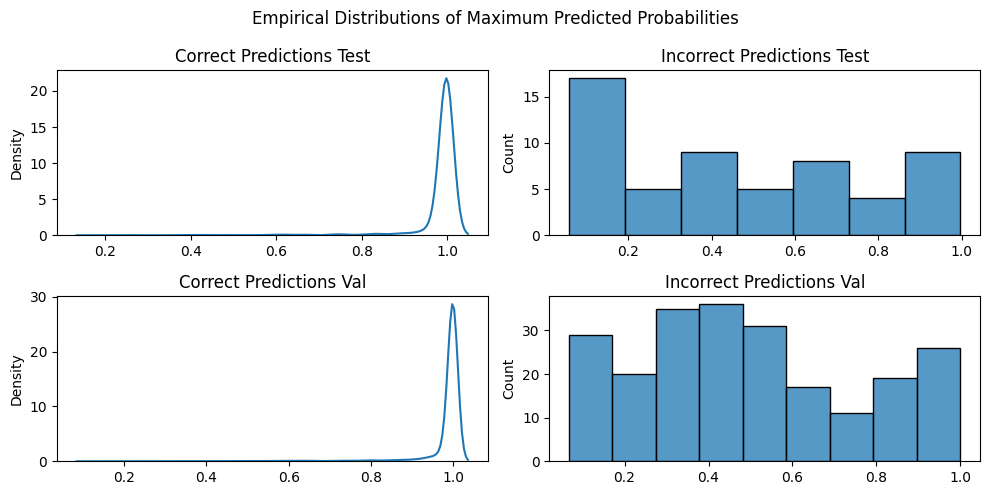

In [ ]:
model = Classifier(                                                    # Define another model instance and load checkpoint weights for evaluation.
    dense1_kernel_reg=ortho_reg_cols, 
    dense2_kernel_reg=ortho_reg_rows, 
    logits_kernel_reg=ortho_reg_cols, 
    **model_kwargs
)
model.load_weights(model_checkpoint)

model.trainable = True
for layer in model.layers:
    layer.trainable = False
model.get_layer(model.layers[-2].name).trainable = True

model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)
#with capture_output() as cap:
history_temp = model.fit(val_ds, epochs=10)
evaluate_probabilistic_accuracy(model, val_ds, test_ds)

**Temperature scaling** reduced the tendency for incorrect predictions to cluster near 1. Results are summarized below.

### *b) Results*

**Before temperature scaling**

- Brier (Test): 0.0467
- Brier (Val): 0.0452

**After temperature scaling**

- Brier (Test): 0.0464
- Brier (Val): 0.0449


***
## **Stratified K-fold Cross Validation**

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f


 --------------------------------------------------------------------------------------------------------------
                                               KFOLD SPLIT #1/4                                                



<Figure size 1800x800 with 0 Axes>

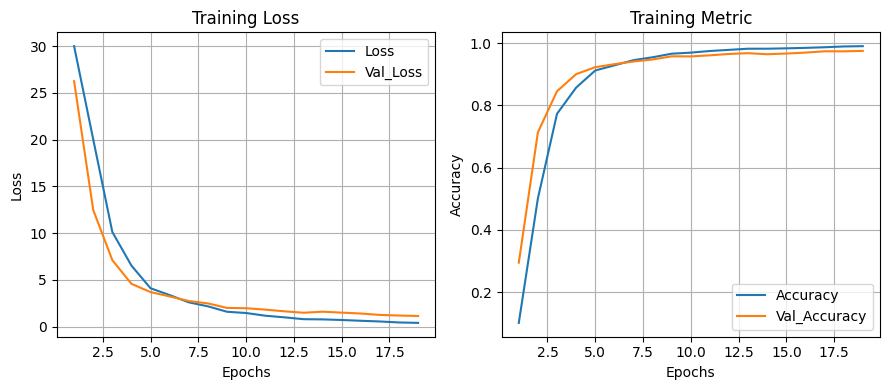

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Weighted Test (last epoch) Set F1-score : 0.9744
Weighted Test (last epoch) Set Recall   : 0.9756
Weighted Test (last epoch) Set Precision: 0.9781
         Test (last epoch) Set Accuracy : 0.9756

54/54 [==============================] - 1s 10ms/step
Model Brier Score - Evaluated over the Test Set: 0.0354
Model Brier Score - Evaluated over the Val Set: 0.0355


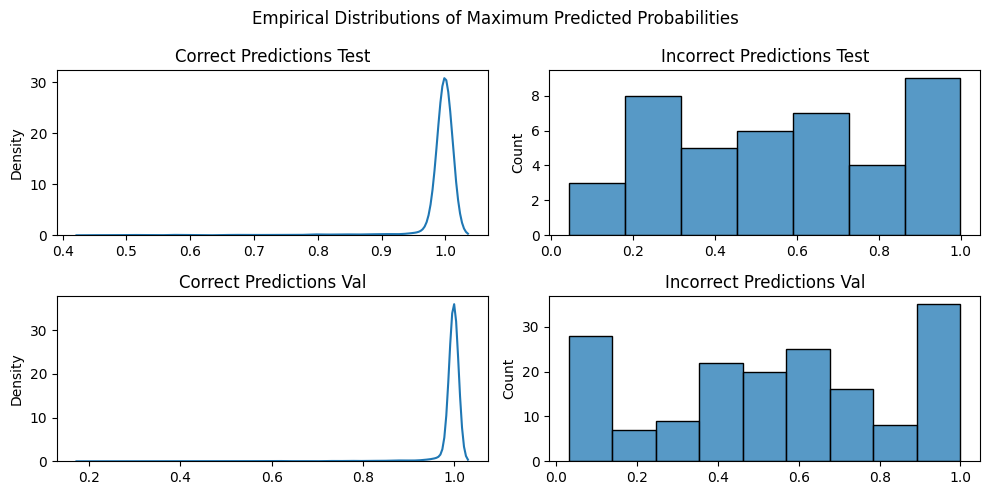


 --------------------------------------------------------------------------------------------------------------


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f


 --------------------------------------------------------------------------------------------------------------
                                               KFOLD SPLIT #2/4                                                



<Figure size 1800x800 with 0 Axes>

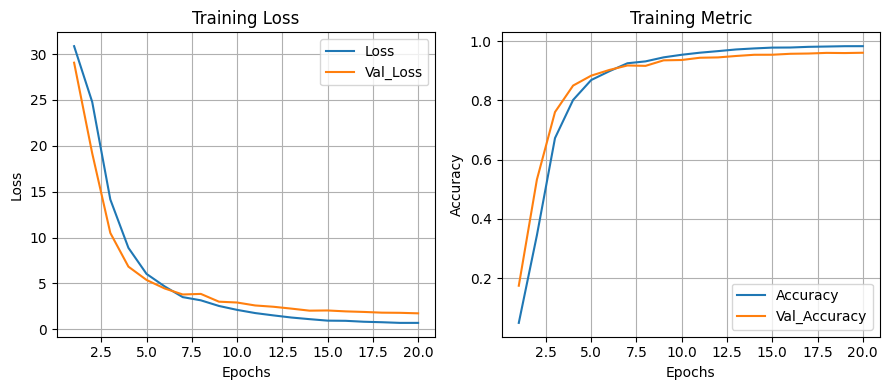

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Weighted Test (last epoch) Set F1-score : 0.9596
Weighted Test (last epoch) Set Recall   : 0.9616
Weighted Test (last epoch) Set Precision: 0.9663
         Test (last epoch) Set Accuracy : 0.9616

54/54 [==============================] - 1s 10ms/step
Model Brier Score - Evaluated over the Test Set: 0.0547
Model Brier Score - Evaluated over the Val Set: 0.0550


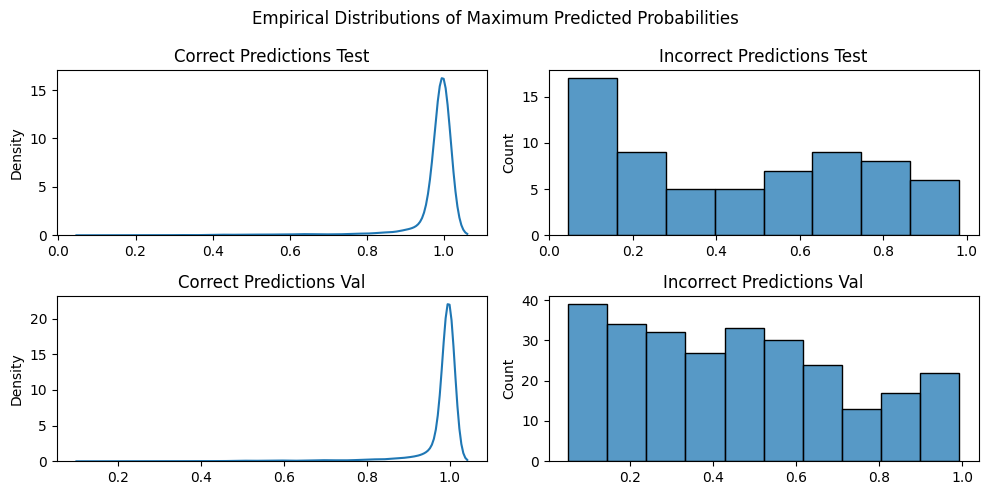


 --------------------------------------------------------------------------------------------------------------


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f


 --------------------------------------------------------------------------------------------------------------
                                               KFOLD SPLIT #3/4                                                



<Figure size 1800x800 with 0 Axes>

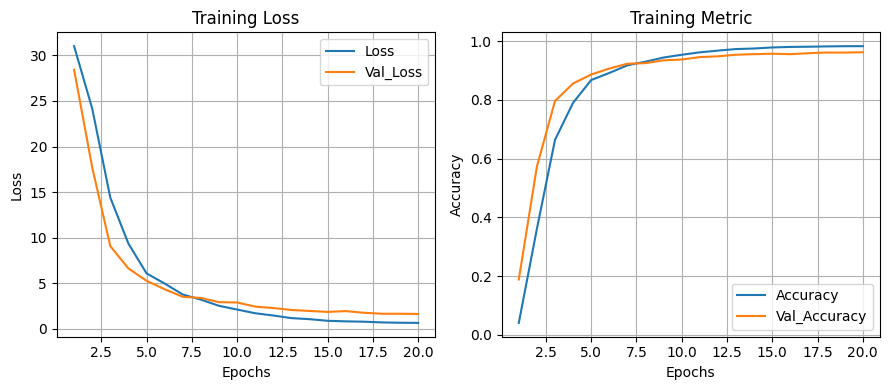

W0000 00:00:1769414597.472321  129023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769414597.474092  129023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769414597.475894  129023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769414597.477919  129023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769414597.479704  129023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769414597.482239  129023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769414597.484200  129023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769414597.486056  129023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769414597.487875  129023 gp


Weighted Test (last epoch) Set F1-score : 0.9630
Weighted Test (last epoch) Set Recall   : 0.9645
Weighted Test (last epoch) Set Precision: 0.9691
         Test (last epoch) Set Accuracy : 0.9645

14/14 [==============================] - 0s 13ms/step
     12/Unknown - 0s 10ms/step

W0000 00:00:1769414598.279359  129023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769414598.281380  129023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769414598.283959  129023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769414598.286211  129023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769414598.287791  129023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769414598.290071  129023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769414598.291807  129023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769414598.293674  129023 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769414598.295491  129023 gp

54/54 [==============================] - 1s 10ms/step
Model Brier Score - Evaluated over the Test Set: 0.0507
Model Brier Score - Evaluated over the Val Set: 0.0511


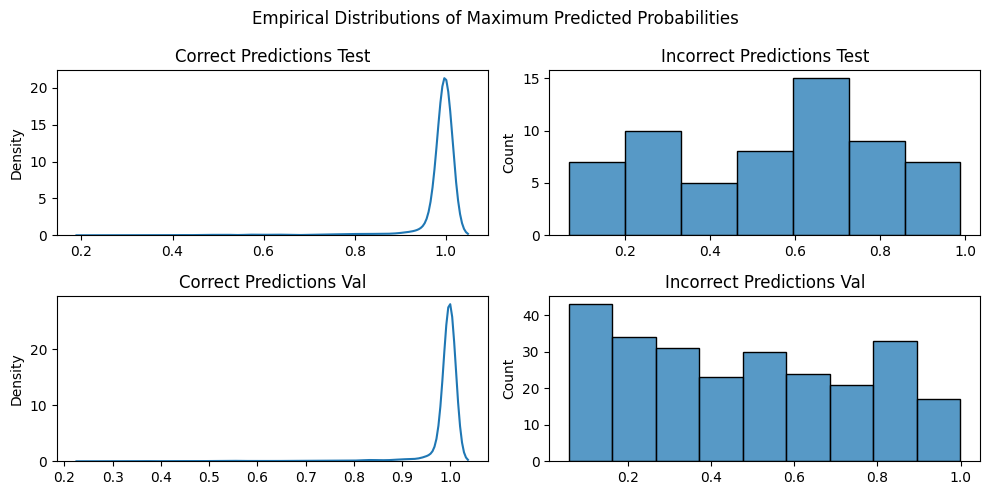


 --------------------------------------------------------------------------------------------------------------


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f


 --------------------------------------------------------------------------------------------------------------
                                               KFOLD SPLIT #4/4                                                



<Figure size 1800x800 with 0 Axes>

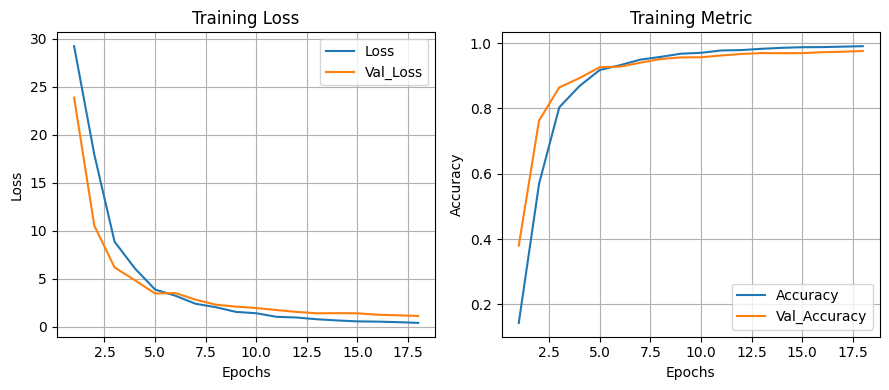

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Weighted Test (last epoch) Set F1-score : 0.9771
Weighted Test (last epoch) Set Recall   : 0.9785
Weighted Test (last epoch) Set Precision: 0.9818
         Test (last epoch) Set Accuracy : 0.9785

54/54 [==============================] - 1s 10ms/step
Model Brier Score - Evaluated over the Test Set: 0.0313
Model Brier Score - Evaluated over the Val Set: 0.0350


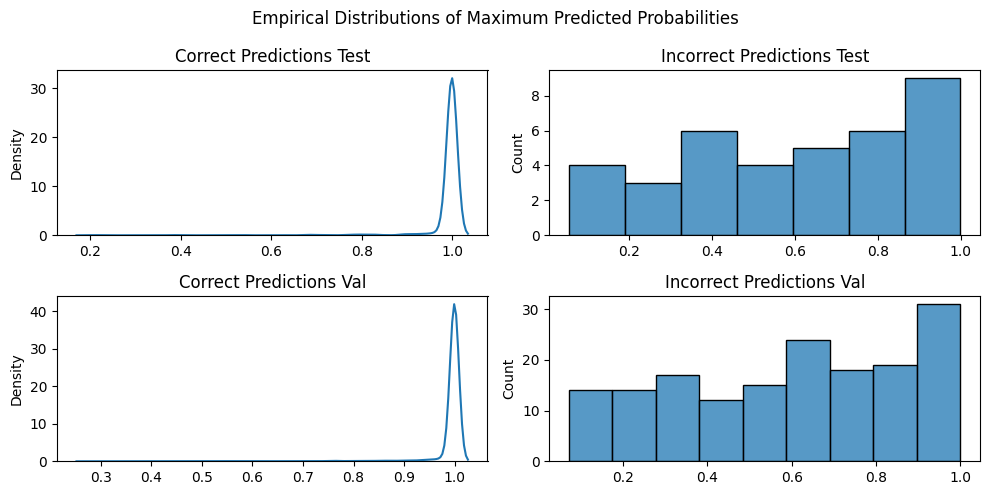


 --------------------------------------------------------------------------------------------------------------


In [206]:
del_objs = [
    'X_train', 'X_temp', 'X_val', 'X_test', 'y_train', 'y_temp', 'y_val', 'y_test', 'model', 'train_ds', 'val_ds', 'test_ds'
    ]
for name in del_objs:
    if name in globals():
        del globals()[name]
gc.collect()
tf.keras.backend.clear_session()

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=seed)                                            
for i, (train_idx, temp_idx) in enumerate(skf.split(inputs, np.argmax(targets, axis=-1))):                       # Iterate through k-fold splits.
    
    X_train, y_train = inputs[train_idx, :, :], targets[train_idx, :]                                  
    X_temp, y_temp = inputs[temp_idx, :, :], targets[temp_idx, :] 
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=np.argmax(y_temp, axis=-1), test_size=.20, shuffle=True, random_state=seed)

    train_ds = make_ds(X_train, y_train, BATCH_SIZE, training=True, shuffle_buf=5000, random_seed=seed)          # Create datasets.
    val_ds   = make_ds(X_val, y_val, BATCH_SIZE, training=False)
    test_ds  = make_ds(X_test, y_test, BATCH_SIZE, training=False)

    model_kfold = Classifier(
        dense1_kernel_reg=ortho_reg_cols, 
        dense2_kernel_reg=ortho_reg_rows, 
        logits_kernel_reg=ortho_reg_cols, 
        **model_kwargs
    )  
    model_kfold.compile(
        loss=loss_fn,
        metrics=['accuracy'],
        optimizer=tf.keras.optimizers.Adam(lr_schedule, beta_1=.95, beta_2=.97)
    )
    with capture_output() as cap:
        history_kfold = model_kfold.fit(train_ds, validation_data=val_ds, verbose=0, epochs=EPOCHS, callbacks=[early_stop])
    
    for layer in model_kfold.layers:
        layer.trainable = False
    model_kfold.get_layer(model_kfold.layers[-2].name).trainable = True
    
    model_kfold.compile(
        optimizer=tf.keras.optimizers.SGD(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    with capture_output() as cap:
        history_temp = model_kfold.fit(val_ds, epochs=10)
    
    print("\n", "-"*110)
    print(f"KFOLD SPLIT #{i+1}/4".center(110), "\n")
    plot_training(history_kfold, figsize=(18, 8))
    evaluate_model(model_kfold, test_ds, set_name='Test (last epoch)')
    evaluate_probabilistic_accuracy(model_kfold, val_ds, test_ds)
    print("\n", "-"*110)

    del_objs = [
    'X_train', 'X_temp', 'X_val', 'X_test', 'y_train', 'y_temp', 'y_val', 'y_test', 'model_kfold', 'train_ds', 'val_ds', 'test_ds'
    ]
    for name in del_objs:
        if name in globals():
            del globals()[name]
    gc.collect()
    tf.keras.backend.clear_session()


### *a) Results*

**Fold-level results (weighted, test set)**

- Fold 1: Acc 0.9756, F1 0.9744, Brier(test) 0.0354
- Fold 2: Acc 0.9616, F1 0.9596, Brier(test) 0.0547
- Fold 3: Acc 0.9645, F1 0.9630, Brier(test) 0.0507
- Fold 4: Acc 0.9785, F1 0.9771, Brier(test) 0.0313

**Aggregate (across folds)**

- Mean test accuracy: 0.9701
- Std test accuracy: 0.0083
- Mean test F1: 0.9685
- Mean Brier(test): 0.0430
- Std Brier(test): 0.0114


***
## **Summary**

- The model achieves ~97% weighted accuracy and ~0.965 weighted F1 on a large 317-class speaker ID task using MFCC + delta features.

- Using Brier loss (scaled for mixed precision) provides a direct optimization target for probability quality, not just classification correctness.

- Calibration analysis shows that high accuracy does not guarantee well-calibrated confidence, and temperature scaling is a lightweight, effective fix.

- Stratified k-fold results suggest the model is robust: it's performance is not sensitive to choice of train-validation-test split.
